## Introduction

This tutorial will walk you through the KNN algorithm. In this tutorial I will introduce the fundamental idea of KNN, implement the algorithm both from scratch and by taking advantages of available library, apply them on a dataset and visualize and analyze the correctness of the prediction result. 

**Note: ** In proposal I intented to introduce both K-means and KNN algotithms, but since K-means has been basically covered in the recent lectures, I decided not to include its detail and just mention a little, and emphasize more on KNN in this tutorial.  

## Installation

In this tutorial we just use some common libraries (numpy, scikit-learn, matplotlib) which should have already been installed by Anaconda.

In case you want to use it outside Anaconda, you can also install these libraries using `pip`, such as:

    $ pip install --upgrade scikit-learn
    


## Overview about KNN

KNN, or K-Nearest Neighbor algorithm is one of the easiest algorithm which can be used for both data classification or regression (In this turorial we provide examples for classification). As its name suggests, the very basic idea of classification of this algorithm is to find k nearest neighbors of one element which is to be classfied, and based on the information of these neighbors we can decide which exact class that this element belongs to.

Although it is not the most powerful algorithm for classfication, it is still has its popularity in many fields, like providing a benchmark for other algorithms, thanks to its simplicity. 

In addition, KNN is a **Non-parametric** approach, so it will not be limited even if the data doesn't curve any distribution pattern very well. For example, KNN can do classification much better for the data which gather together as a cluster than the simple linear classification. Because we can hardly separate the classes using a single line.

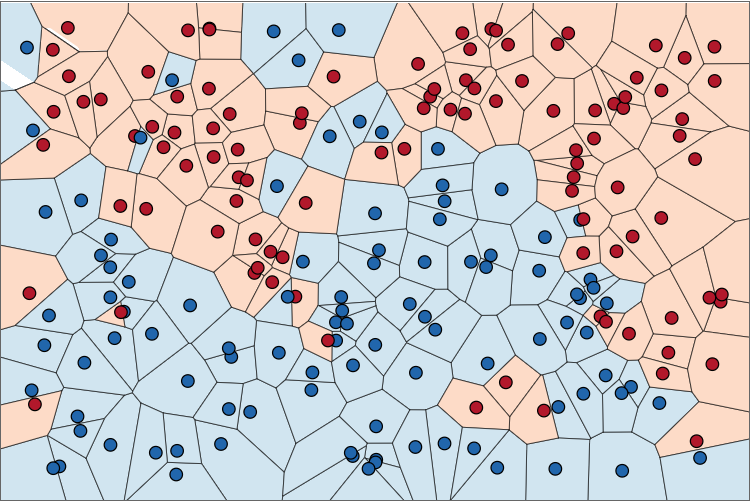

### Distance

By neareast, it essentially means the most similar data instance. The distance is an analogy of the similarity of features, and can be measured with different strategies according to the data type. 

The most widly used distance metric is **Euclidean distance** function:

\begin{equation}
    dist(A,B) = \sqrt{\frac{\sum_{i=1}^{m} (x_i−y_i)^2}{m}}
\end{equation}

For those data with quantifiable features, Eucilidean distance is very convenient for distance measurement and is intuitively fit. 

Another commonly used distance measurement approach is what we have learned in language text processing lectures: **Cosine similarity**. 

\begin{equation}
    dist(A,B) = \frac{\overrightarrow{A} \cdot \overrightarrow{B}} {\lvert\overrightarrow{A}\rvert \lvert\overrightarrow{B}\rvert} 
\end{equation}

This is a popular method to calculate similarity between documents in information retrieve field.

Other distance metrics include Minkowsky distance, Manhattan distance and so on. You can check their implementation and suitable scenarios here [DistanceMetric](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) 


### Neighbors

KNN falls in the supervised learning algorithm. It is important to mention that strictly speaking KNN doesn't have a training process like many other machine learning approaches do. Instead it is an **instance-based** leanring algorithm, which means this algorithm store all its knowledge in memory, and make predictions based on these knowledge *directly*, rather than training a prediction pattern or model.

In prediction phase, now that we already have lots of "knowledge", for every input, we check its `K` neareast neighbors in trainng set based on the distance which we previously defined. (`K` is a self-defined parameter or hyperparameter) Then the class that most of these neighbors fall in will be the very class that our prediction suggests.

To give you a more intuitive sense of how this algoithm works, the picture below from [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) will help you to understand the idea in it. 

![KNN_example](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)



In the graph above, red triangles and blue squares are known information (training set) and the green circle is a test instance. if we set the hyperparameter `K` to be 3, which can be represented by the inner circle. Among the 3 closest neighbors of the green circle, two of them are red triangle while the other one is the blue square. Therefore, according to our classification rule, the test data should be in the red triangle class.

If we set our hyperparameter `K` to be 5, which can be represented by the outer dashed circle. Similarly the test data will be classified to blue square class since three of its closest neighbors are blue square while 2 of them are red triangle. 

## CIFAR-10 Example

As you can see, KNN algorithm is really intuitive and easy to understand, and to implement as well! In this section we will apply KNN to the CIFAR-10 dataset. CIFAR-10 dataset is a public dataset consisting of 60000 32\*32 sized images in 10 classes containing 6000 images each. There are 5000 training images and 1000 testing images per class.

You can find more details about the data in the [official site](https://www.cs.toronto.edu/~kriz/cifar.html).

### Load and process data

The data can be downloaded directly from the official site. Since its kind of large (167MB), I put it on S3 Bucket and our code should do the downloading staff first.

Note the code below currently can't work on Windows system. You can alternatively get the data [here](https://s3.amazonaws.com/pds-cxw/CIFAR-10/cifar-10-batches-py.zip) and untar all files into the same directory with the notebook.

In [ ]:
'''
    Downloading dataset from S3 Bucket.
'''
from subprocess import call

print("Downloading starts...")
call(["wget", "https://s3.amazonaws.com/pds-cxw/CIFAR-10/test_batch"])
call(["wget", "https://s3.amazonaws.com/pds-cxw/CIFAR-10/data_batch_1"])
call(["wget", "https://s3.amazonaws.com/pds-cxw/CIFAR-10/data_batch_2"])
call(["wget", "https://s3.amazonaws.com/pds-cxw/CIFAR-10/data_batch_3"])
call(["wget", "https://s3.amazonaws.com/pds-cxw/CIFAR-10/data_batch_4"])
call(["wget", "https://s3.amazonaws.com/pds-cxw/CIFAR-10/data_batch_5"])
print("Done")

The dataset contains a `test` file and a `train` file. In `train` file there are 5000 samples in each class, while in `test` file there are 1000 samples in each class.

The test data was given in 5 batch file, so I need to concat the dict one by one.

In [184]:
import numpy as np
import pickle as pk
import collections 
import math

def load_from_file():
    
    path_root = 'data_batch_'
    dict_train = {}
    
    # read 5 raw training data files
    for i in range(1,6):
        path_concat = path_root + str(i)
        with open(path_concat, 'rb') as f:
            dict_temp = pk.load(f, encoding='bytes')
        if len(dict_train) == 0:
            dict_train = dict_temp
        else:
            dict_train[b'data'] = np.append(dict_train[b'data'], dict_temp[b'data'], axis=0)
            dict_train[b'labels'] = np.append(dict_train[b'labels'], dict_temp[b'labels'])
    dict_test = {}
    
    # read test data file
    with open("test_batch", 'rb') as f:
        dict_test = pk.load(f, encoding='bytes')
    return dict_train, dict_test

dict_train, dict_test = load_from_file()


Now we have loaded the training and test datasets. Let's have a look at the structure of the data and get a sense of what it contains. 

In [185]:
print("Keys: \n\t", dict_train.keys())

train_data_list = dict_train[b'data']
train_label_list = dict_train[b'labels']
test_data_list = dict_test[b'data']
test_label_list = dict_test[b'labels']

print("\nSamples in each superclass: \n", dict(collections.Counter(train_label_list)))
print("\nWhat does data look like: \n", train_data_list[:5])
print("\nlen(data): ", len(train_data_list))


Keys: 
	 dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Samples in each superclass: 
 {6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}

What does data look like: 
 [[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]

len(data):  50000


    We notice that the data for each sample has a length of 3072 = 3\*32\*32, where 32\*32 is the size and the 3 here means the images are colored with RGB dimensions
    
    We want to do some modification to the dataset because the data is way to large for the tutorial in computation. We decrease the training set into 3000 samples per class for better usability.
    
    

In [186]:
# rescale the data size for better usability.

def shrink(data_list, label_list, size=3000):
    count_dict = {x:0 for x in range(10)}
    
    new_data_list = []
    new_label_list = []
    
    # iterate over data_list and label_list until each class has reached its expected size
    for i in range(len(data_list)):
        if count_dict[label_list[i]] < size:
            count_dict[label_list[i]] += 1
            new_data_list.append(data_list[i])
            new_label_list.append(label_list[i])
    return new_data_list, new_label_list

train_data_list, train_label_list = shrink(train_data_list, train_label_list)

# validate the result.
print("\nSamples in each superclass: \n", dict(collections.Counter(train_label_list)))


Samples in each superclass: 
 {6: 3000, 9: 3000, 4: 3000, 1: 3000, 2: 3000, 7: 3000, 8: 3000, 3: 3000, 5: 3000, 0: 3000}


### Define distance metric

Obviously, the **Euclidean distance** is a good choice here since the data are all numerical with the same structure.

As you may already notice, the calculation can be a large overhead here if we compute the distance between all this 3072 dimension vectors. Here we can introduce a `step` concept, indicating how many element we skip in each interation when we are computing the similarity distance, which is somewhat like a [`pooling`](http://ufldl.stanford.edu/tutorial/supervised/Pooling/) approach. It is true that we may sacrifice some accuracy but we can get better running performance and usability.

Besides, since the distance comparison will not be influenced by the `sqrt` or `square` operation (all distances are positive numbers), actually we can just ignore the `sqrt` operation for simplicity. 

In [187]:
def get_distance(data_1, data_2, step=2):
    
    dist = 0
    
    for i in range(0, len(data_1), step):
        
        dist += pow((int(data_1[i]) - int(data_2[i])), 2)
    
    # Skip sqrt()
    return dist

### Find neighbors

Again, KNN is a instance-based approach and doesn't train a prediction model. So once the training data has been loaded into the memory, we are ready to make the prediction for test code.

First we find the `K` nearest neighbors for the input test instance. We denote them by the their index in the `train_label` list.


In [188]:
def get_neighbors(data_test, train_data_list, K, step):

    dist_list = []
    
    # Compute the distance between all the other data in training set.
    for i in range(0, len(train_data_list)):
        dist = get_distance(train_data_list[i], data_test, step)
        dist_list.append(dist)
    # Use numpy.argpartition to select K smallest element in a list.
    dist_np_array = np.array(dist_list)
    k_index = np.argpartition(dist_list, K)
    
    return k_index[:K]
# get_neighbors(test_data_list[1], train_data_list, 3, 200)

### Make decision

We have got the K nearest neighbors, we need to find the most common class in these neighbors.


In [189]:
import operator

def make_decision(k_index, train_label_list):
    
    # A dict with structure : {class : count}
    dict_vote = {}
    
    for i in k_index:
        if train_label_list[i] in dict_vote.keys():
            dict_vote[train_label_list[i]] += 1
        else:
            dict_vote[train_label_list[i]] = 1
            
    # return the key with the max value in this dict
    return max(dict_vote.items(), key=operator.itemgetter(1))[0]

make_decision([24,31,55,11,44,52], train_label_list)

2

### Make prediction on test data

Now that we have implemented all functions we need for the classfication, it's time to make prediction on the test dataset.


Since the calculation was really time consuming, the strategy here is to randomly choose some test samples to do the test for subsequent correctness validation.

In [190]:
# generate a index list randomly

import random

def get_random_list(n):
    rand_list = []
    for i in range(n):
        rand_list.append(random.randrange(10000))
    print("random list:", rand_list)
    return rand_list


In [203]:
%%time

rand_list = get_random_list(20)

def KNN(K, step, rand_list):
  
    y_labels = []

    i=0
    for r in rand_list:
        neighbor_list = get_neighbors(test_data_list[r], train_data_list, K, step)
        y = make_decision(neighbor_list, train_label_list)
        # build the label prediction list 
        y_labels.append(y)
        # for debugging purposes
        print("sample", i, "prediction:", y, "true label:", test_label_list[r])
        i+=1

    return y_labels

# t = KNN(5, 5, rand_list)

random list: [1929, 7985, 2318, 3311, 162, 7232, 8980, 3543, 6313, 7358, 6150, 7226, 7715, 4721, 3775, 6023, 2923, 1296, 3386, 1858]
Wall time: 0 ns


### Evaluate the result

Let's compare our prediction with the correct classfication to see how well our KNN performs. We can also check how the correctness varies if we change the hyperparameters `step` and `K`.



In [204]:
%%time

def evaluate_prediction(y_labels, true_labels, rand_list):
    n = len(y_labels)
    match = 0
    for i in range(n):
#         print("prediction: ", y_labels[i],  "true label: ", true_labels[rand_list[i]])
        if y_labels[i] == true_labels[rand_list[i]]:
            match += 1
    print("Correctness: ", match/n)
    return match/n
# evaluate_prediction(t, test_label_list, rand_list)

Wall time: 0 ns


Then let us try with different hyperparameters, and calculate their correctness respectively.

Here we use K with values 3, 5, 8, 12 and step = 10

In [205]:
rand_list = get_random_list(20)
k_list = [3, 5, 8, 12]
correctness_list = []

for k in k_list:
    print("K =",k)
    y = KNN(k, 10, rand_list)
    correctness = evaluate_prediction(y, test_label_list, rand_list)
    correctness_list.append(correctness)
    



random list: [6763, 5825, 3173, 4918, 4837, 6293, 6518, 9778, 9362, 6994, 5012, 1573, 930, 7779, 8029, 544, 2952, 9089, 6421, 7019]
K = 3
sample 0 prediction: 4 true label: 2
sample 1 prediction: 6 true label: 3
sample 2 prediction: 2 true label: 9
sample 3 prediction: 3 true label: 3
sample 4 prediction: 6 true label: 7
sample 5 prediction: 7 true label: 3
sample 6 prediction: 6 true label: 6
sample 7 prediction: 5 true label: 3
sample 8 prediction: 1 true label: 9
sample 9 prediction: 2 true label: 3
sample 10 prediction: 4 true label: 6
sample 11 prediction: 0 true label: 0
sample 12 prediction: 6 true label: 4
sample 13 prediction: 6 true label: 5
sample 14 prediction: 4 true label: 7
sample 15 prediction: 5 true label: 5
sample 16 prediction: 6 true label: 3
sample 17 prediction: 5 true label: 3
sample 18 prediction: 2 true label: 6
sample 19 prediction: 2 true label: 2
Correctness:  0.25
K = 5
sample 0 prediction: 4 true label: 2
sample 1 prediction: 6 true label: 3
sample 2 pred

[3, 5, 8, 12] [0.25, 0.2, 0.2, 0.15]


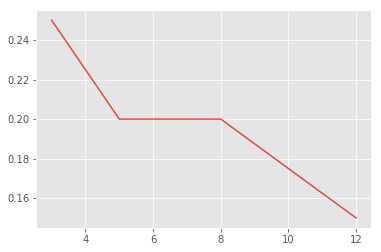

In [216]:
import matplotlib
# Use svg backend for better quality
# AUTOLAB_IGNORE_START
%matplotlib inline
# matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt

print(k_list, correctness_list)
plt.plot(k_list, correctness_list)
plt.show()



Honestly the result is horrible here (even with the built-in function which is provided below, without `step`). Despite we make many simplifications which affect the correctness, KNN is not very fit for these data. It may behave better for grey-scaled photos.

### KNN with library

Just as other popular classfication methods, there are also some built-in implementations in related library, such as `scikit-learn`. In this section we will use the library implementation to do the KNN classfication on the same dataset.



In [217]:
%%time
from sklearn.neighbors import KNeighborsClassifier

rand_list = get_random_list(100)

def KNN_sk(K, rand_list):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_data_list, train_label_list)
    rand_test_list = []
    for i in rand_list:
        rand_test_list.append(test_data_list[i])
    return knn.predict(rand_test_list)

y_sk = KNN_sk(5, rand_list)
evaluate_prediction(y_sk, test_label_list, rand_list)


random list: [1379, 9458, 2079, 2405, 8944, 6358, 2202, 8732, 4422, 3527, 8189, 7629, 2187, 8119, 1583, 9037, 3078, 3551, 9472, 1447, 9325, 3796, 1671, 8940, 2539, 6049, 8219, 1300, 75, 6084, 8671, 1708, 7057, 1047, 8401, 1327, 49, 3846, 196, 3603, 9996, 2931, 7342, 5431, 1176, 6842, 447, 9443, 8018, 4142, 1320, 6850, 8144, 3622, 5028, 1891, 6211, 6445, 7492, 8087, 8937, 483, 4618, 4370, 9389, 2035, 1095, 5409, 5693, 1049, 1027, 2834, 2016, 820, 267, 1841, 3176, 103, 3830, 3613, 1343, 3269, 1598, 3641, 5739, 5028, 4485, 9445, 2591, 536, 7159, 223, 6060, 500, 5037, 8394, 1042, 2438, 9868, 3769]
Correctness:  0.27
Wall time: 32.5 s


### The insight of K

Until now we haven't discussed how to make the best choice of K. In fact, just like other hyperparameters (N in N-Gram), we ourselve need to figure out what would be the best value of K. Besides, since KNN is a instance-based algorithm, the performance is highly related with the training sample and test sample. Imagine in the worst case, a test instances may be "surrounded" by the same other instances of another class, which is actually not the class that the test instance belongs to. And when the circle grows larger, it will be more informative that what is the real distribution around it. These requires us to do more inspection to the data, or use some techniques like cross validation.

## KNN vs K-means

KNN and K-means have some similarity in some intuitive sense. For example, they both put similar data together, and they both do this based on some distance metrics rather than some distribution pattern. However, they are fundamentally different approach: one is unsupervised and the other is supervised. Below listed some comparisons in detail about these two methods.

| KNN                                                                                 | K-means                                                                       |   |   |
|-------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|---|---|
| Classification algorithm. Supervised with correctly labeled data in training phase. | Clustering algorithm. Unsupervised with unlabeled data fed in training phase. |   |   |
| No explicitly training process.                                                     | Has a training process in early time.                                         |   |   |
| K means the number of neighbors that we should ask for vote.                        | K means the number of clusters that we want after running the algorithm.      |   |   |

## Summary and References

1. [CIFAR Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)
2. [A reference tutorial](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)
3. [An Guide to KNN](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/)